Tasks:
* Create cronjob
* Web scrapping
* Download zip file
* Unzip it
* Read file which name start with "lotto_"

Preparation:
* Read file
* Extract columns 'boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'numero_chance', year
* Set custom range of rows (slider or input), predefine ranges - last 50, all, etc.

Analysis:
* Odd / Even - (3 odd + 2 even - 814 times)
* Define patterns: (1-9 - blue, 10-19 - yellow, etc) occurencies (by year) count and PROBABILITY https://lottometrix.com/members/analysis-euromillions.php
* Top Hot - most occurencies in row range
* Top Cold - less occurencies on row range
* Overdue - Number which isn't drawn for a long time (show be beyond range)
* Pairs and frequency (2,14 - 5 times)
* Sum and frequency (sum of all numbers: 132 - 56 times)
* Low / High - split on 24(or 25) occurencies - (3 low, 2 high - 529 times)
* Consecutives (0 - 1144 times, 1 - 311 times)
* Regularity (each number is + 7) or (+7 +8 + 9 etc)
* Following numbers
* Non following numbers
* Average numbers
* Heat map chart

AI:
* Split analysis on two groups: probability and history. Set each of them value. History value should be lesser than prob one

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Web scrapping
import requests
import zipfile
import os

def download_and_extract_zip(url, destination_folder):
    # Step 1: Download the zip file
    response = requests.get(url)
    
    if response.status_code == 200:
        # Step 2: Save the zip file locally
        zip_filename = "downloaded_file.zip"
        with open(zip_filename, 'wb') as f:
            f.write(response.content)

        # Step 3: Extract the contents of the zip file
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)

        # Step 4: Delete the zip file
        os.remove(zip_filename)
        print(f"Downloaded and extracted successfully to {destination_folder}")
    else:
        print(f"Failed to download the file. HTTP status code: {response.status_code}")

# Example usage
url_to_zip = "https://media.fdj.fr/static-draws/csv/loto/loto_201911.zip"
download_destination = "./"

download_and_extract_zip(url_to_zip, download_destination)

Downloaded and extracted successfully to ./


In [3]:
file_name = "loto_201911.csv"
# Create a DataFrame with all possible numbers from 1 to 49
all_numbers = pd.DataFrame({'number': range(1, 50)})

In [4]:
df = pd.read_csv(file_name, sep=";")

In [5]:
df = df[['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5', 'numero_chance', 'date_de_tirage']]

In [6]:
df.head()

,boule_1,boule_2,boule_3,boule_4,boule_5,numero_chance,date_de_tirage
0,19,41,42,43,45,2,20/01/2024
1,29,8,37,22,39,10,17/01/2024
2,11,7,15,23,19,4,15/01/2024
3,12,15,21,29,48,6,13/01/2024
4,12,28,32,45,38,9,10/01/2024


In [7]:
range_col = df['numero_chance']

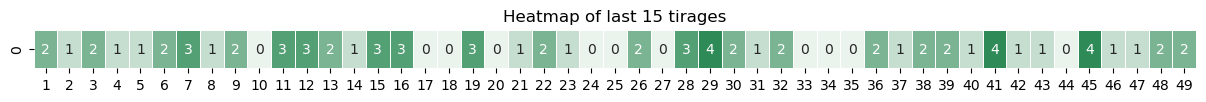

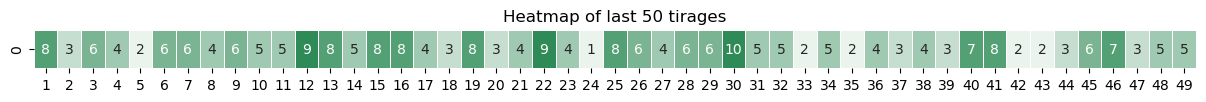

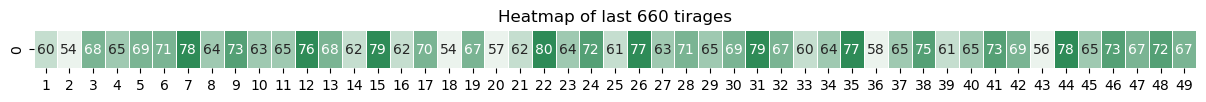

In [8]:
# HEATMAP
def exctract_data_frame(data_frame, first_n_rows=None):
    if first_n_rows is None:
        return data_frame.copy()  # Return a copy of the entire DataFrame
    else:
        return data_frame.truncate(before=0, after=first_n_rows - 1) # starts from 0
    

def show_heat_map(last_tirages=None):
    extracted_df = exctract_data_frame(df, last_tirages)
    # print(extracted_df.head())
    
    # Reshape the DataFrame to a single column
    flat_df = pd.melt(extracted_df, value_vars=['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5'],
                      var_name='boule', value_name='number')
    # print(f'Melt:\n{flat_df}')
    
    tirages_count = int(len(flat_df) / 5)

    # Create a pivot table to count the occurrences of each number
    heatmap_data = flat_df.pivot_table(index='number', aggfunc='size', fill_value=0)
    # print(f'Pivot:\n {heatmap_data}')
    
    # Add missing values from 1 to 49 with a count of 0
    heatmap_data = heatmap_data.reindex(index=range(1, 50), fill_value=0)
    # print(f'Pivot 2:\n {heatmap_data}')

    # Get the numbers as the x-axis labels
    numbers = heatmap_data.index
    # print(numbers)

    # Reshape the DataFrame to a 1D array
    heatmap_data = heatmap_data.values

    # Create a heatmap
    plt.figure(figsize=(15, 0.5))
    # print(heatmap_data.reshape(1, -1))
    sns.heatmap(heatmap_data.reshape(1, -1), cmap=sns.light_palette("seagreen"), annot=True, fmt='d', linewidths=.5, cbar=False,
                xticklabels=numbers)
    plt.title(f'Heatmap of last {tirages_count} tirages')
    plt.show()
    # sns.barplot(data=None, x=numbers, y=heatmap_data, width=1, fill=True)

    
show_heat_map(15)
show_heat_map(50)
show_heat_map()

In [9]:
# PATTERNS
dfp = pd.DataFrame(df, columns=['boule_1', 'boule_2', 'boule_3', 'boule_4', 'boule_5']) # TODO add the date
# print(dfp.head())

# Sort the values within each row in ascending order
sorted_df = dfp.apply(lambda row: pd.Series(row.sort_values().values), axis=1)
# print(sorted_df.head())

# Define a function to categorize a number
def categorize_number(number):
    if 1 <= number <= 10:
        return 'yellow'
    elif 11 <= number <= 20:
        return 'green'
    elif 21 <= number <= 30:
        return 'red'
    elif 31 <= number <= 40:
        return 'blue'
    elif 41 <= number <= 49:
        return 'purple'
    else:
        return 'Out of range'

# Apply the categorization function to each element in the DataFrame
categorized_df = sorted_df.apply(lambda col: col.map(categorize_number))

# Join the results to create a 'Pattern' column for each row
categorized_df['Pattern'] = categorized_df.apply(lambda row: '-'.join(row), axis=1)

# Display the result
print(categorized_df.head(50))

# Count occurrences of each unique pattern
pattern_counts = categorized_df['Pattern'].value_counts()

# Display the result
print(pattern_counts)

         0       1       2       3       4                            Pattern
0    green  purple  purple  purple  purple  green-purple-purple-purple-purple
1   yellow     red     red    blue    blue           yellow-red-red-blue-blue
2   yellow   green   green   green     red       yellow-green-green-green-red
3    green   green     red     red  purple         green-green-red-red-purple
4    green     red    blue    blue  purple         green-red-blue-blue-purple
5   yellow   green  purple  purple  purple  yellow-green-purple-purple-purple
6    green     red    blue  purple  purple       green-red-blue-purple-purple
7   yellow  yellow   green    blue  purple    yellow-yellow-green-blue-purple
8   yellow  yellow   green   green  purple   yellow-yellow-green-green-purple
9   yellow   green   green    blue    blue       yellow-green-green-blue-blue
10   green   green     red     red  purple         green-green-red-red-purple
11  yellow  yellow  yellow    blue  purple   yellow-yellow-yello

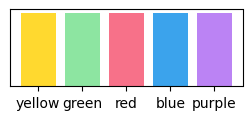

In [10]:
# Define color names and corresponding colors
color_names = ['yellow', 'green', 'red', 'blue', 'purple']
colors = ['#ffd92f', '#8de5a1', '#f77189', '#3ba3ec', '#bb83f4']

# Create a bar plot with color blocks
fig, ax = plt.subplots(figsize=(3, 1))
ax.bar(color_names, [1] * len(color_names), color=colors)

# Remove y-axis ticks and labels
ax.set_yticks([])
ax.set_ylabel('')

plt.show()

In [11]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import to_rgba
import io
import base64

# Sample data
data = {
    'Column 1': [1, 2, 3],
    'Column 2': ['A', 'B', 'C'],
    'Column 3': ['green', 'red', 'blue'],  # Replace with your color names
}

df = pd.DataFrame(data)

# Function to convert color names to HTML with embedded image
def get_color_bar_html(color):
    fig, ax = plt.subplots(figsize=(0.5, 0.1))
    ax.set_axis_off()
    rect = Patch(facecolor=color, edgecolor='black')
    ax.add_patch(rect)

    # Save the figure to a temporary file
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    plt.close(fig)

    # Embed the image in HTML
    encoded = base64.b64encode(buf.getvalue()).decode("utf-8")
    html = f'<img src="data:image/png;base64,{encoded}" />'

    return html

# Apply the function to the desired cell
df.at[1, 'Column 3'] = get_color_bar_html('green')  # Replace 'green' with your color

# Display the DataFrame with the embedded subplot
display(HTML(df.to_html(escape=False)))



NotImplementedError: Derived must override